# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/General_Functions")

CPU times: user 135 µs, sys: 105 µs, total: 240 µs
Wall time: 169 µs


# Agulhas Region

## AVISO Data from Agulhas Region

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 185 ms, sys: 63.3 ms, total: 248 ms
Wall time: 441 ms


## Data/Parameters for Dynamical System

In [3]:
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 16

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Initial time (in days)
t0 = 25

# Final time (in days)
tN = 45

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 5
ymin = -35
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.1
dy = 0.1

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

CPU times: user 238 µs, sys: 104 µs, total: 342 µs
Wall time: 311 µs


In [5]:
# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *

DS = Dynamical_System(params_data, params_DS)

## Velocity Interpolation

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 64.3 ms, sys: 21.2 ms, total: 85.5 ms
Wall time: 109 ms


## Gradient of Flow map over Meshgrid of Initial Conditions

In [7]:
%%time
# aux_grid = True --> Use auxiliary grid for numerical computation of gradient.
# Otherwise aux_grid = False.
aux_grid = True

grad_Fmap_grid = DS._grad_Fmap_grid(aux_grid)

  0%|          | 0/52 [00:00<?, ?it/s]

CPU times: user 1.26 s, sys: 481 ms, total: 1.74 s
Wall time: 11min 58s


## Cauchy-Green strain tensor over Meshgrid of Initial Conditions

In [8]:
B, C = DS._cauchy_green_strain(grad_Fmap_grid)

## Finite Time Lyapunov Exponent (FTLE)

In [9]:
from ipynb.fs.defs.FTLE import _FTLE
FTLE_min, FTLE_max = _FTLE(C, tN-t0, Incompressible)

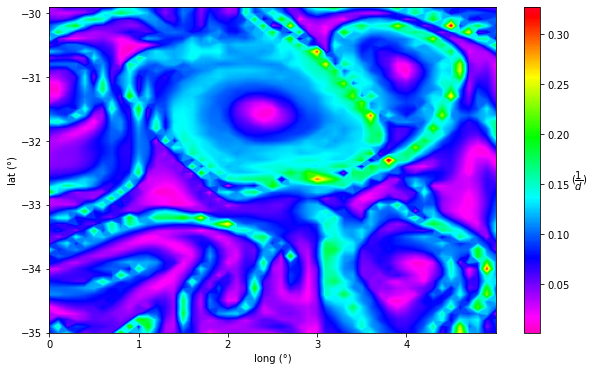

In [12]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, FTLE_max, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)")
ax.set_ylabel("lat (°)")

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .3, 7))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10)

plt.show()